In [0]:
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt
import sys
import numpy as np

In [0]:
(X_train,_), (_, _) = fashion_mnist.load_data()

In [0]:
X_train = X_train/127.5-1

In [0]:
X_train = np.expand_dims(X_train, axis=3)

In [53]:
def build_generator():
  model = Sequential()

  model.add(Dense(256, input_dim=100))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(1024))
  model.add(LeakyReLU(0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(np.prod((28, 28, 1)), activation='tanh'))
  model.add(Reshape((28, 28, 1)))

  model.summary()

  noise = Input(shape=(100,))
  img = model(noise)

  return Model(noise, img)

generator = build_generator()
z = Input(shape=(100,))
img = generator(z)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 512)               2048      
_________________________________________________________________
dense_38 (Dense)             (None, 1024)            

In [54]:
def build_discriminator():
  model = Sequential()

  model.add(Flatten(input_shape=(28, 28, 1)))
  model.add(Dense(512))
  model.add(LeakyReLU(0.2))
  model.add(Dense(256))
  model.add(LeakyReLU(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()

  img = Input(shape=(28, 28, 1))
  validity = model(img)

  return Model(img, validity)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
discriminator.trainable = False

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_______________________________________________

In [0]:
def sample_images(epoch):
  r, c = 5, 5
  noise = np.random.normal(0, 1, (r*c, 100))
  gen_imgs = generator.predict(noise)

  # Rescale images 0 - 1
  gen_imgs = 0.5*gen_imgs+0.5

  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  #fig.savefig("images/%d.png" % epoch)
  plt.show()
  plt.close()

In [63]:

epochs = 10000

batch_size = 32
sample_interval = 100
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))
validity = discriminator(img)
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
for epoch in range(epochs):
  # Train discriminator
  idx = np.random.randint(0, X_train.shape[0], batch_size)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, 100))

  gen_imgs = generator.predict(noise)

  d_loss_real = discriminator.train_on_batch(imgs, valid)
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  d_loss = 0.5*np.add(d_loss_real, d_loss_fake)

  # Train generator
  noise = np.random.normal(0, 1, (batch_size, 100))

  g_loss = combined.train_on_batch(noise, valid)

  if epoch % sample_interval == 0:
    sample_images(epoch)

Output hidden; open in https://colab.research.google.com to view.

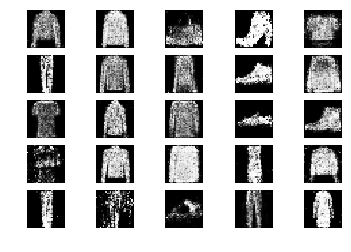

In [64]:
sample_images(10000)